In [15]:
cd(@__DIR__) #src
using Agents, Random
using Agents.DataFrames, Agents.Graphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using CairoMakie
CairoMakie.activate!() # hide
using InteractiveDynamics
using StatsBase
#We initialize the model according to some parameters THAT ARE NOW HARDCODED BUT WILL NOT BE IN A NEAR FUTURE
function  model_init()
    @agent Cell GridAgent{2} begin
        time_alive::Int  # Time the cell has been alive
        near_cells::Int # Number of cells in the neighborhood
        genotype::BitArray # Genotype of the cell
    end

    seed = 0
    rng = MersenneTwister(seed)
    l=10
    n0=10
    ngenes=4
    space = GridSpace((l, l))
    properties=@dict()
    model = ABM(Cell, space;properties, rng) 

    for i in 1:n0
        add_agent!(model,0,0,BitArray([false for x in 1:ngenes]))
    end
    return model
end

#Step evey agent, updating its parameters and then reproducing, moving and dying.
function agent_step!(agent, model)
    if agent.time_alive == 0
        mutate!(agent,model)
    end
    agent.time_alive += 1
    agent.near_cells = length(ids_in_position(agent, model))
    reproduce!(agent, model)
    move!(agent, model)
    die!(agent, model)
end

#Move every cell to a random nearby space ONLY if your space is "crowded", crowded for example is more than 1 cell in your space 
function move!(agent, model)
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    newpos = rand(model.rng, nearby)
    if length(ids_in_position(agent, model)) > 1
        m = sample(nearby)
        move_agent!(agent,m, model)
    end
end

#reproduce, creating a new cell in the same space with a probability that decreases with how many cells are already in its space
function reproduce!(agent,model)
    pid = agent.pos
    if rand(model.rng) < 0.01/(length(ids_in_position(agent, model))^2)
        add_agent!(pid,model,0,0,agent.genotype)
    end
end

#with a probability p choose a random non mutated gene and mutate it. TODO
function mutate!(agent,model)
    agent.genotype
end

#die, with a probability that increases with the number of cells that are in its space.
function die!(agent, model)
    pos = agent.pos
    nearby = [x for x in nearby_positions(agent,model,1)]
    if rand(model.rng) < 0.01*(length(ids_in_position(agent, model))^2)
        kill_agent!(agent, model)
    end
end


model = model_init()
println(model)
#we collect the number of cells that are alive
to_collect = [(:time_alive, length)]
#we run the simulation
data, _ = run!(model, agent_step!, 10; adata = to_collect)

AgentBasedModel with 10 agents of type Cell
 space: GridSpace with size (10, 10), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: 


(11×2 DataFrame
 Row │ step   length_time_alive 
     │ Int64  Int64             
─────┼──────────────────────────
   1 │     0                 10
   2 │     1                 11
   3 │     2                 11
   4 │     3                 11
   5 │     4                 11
   6 │     5                 11
   7 │     6                 12
   8 │     7                 12
   9 │     8                 12
  10 │     9                 13
  11 │    10                 12, 0×0 DataFrame)

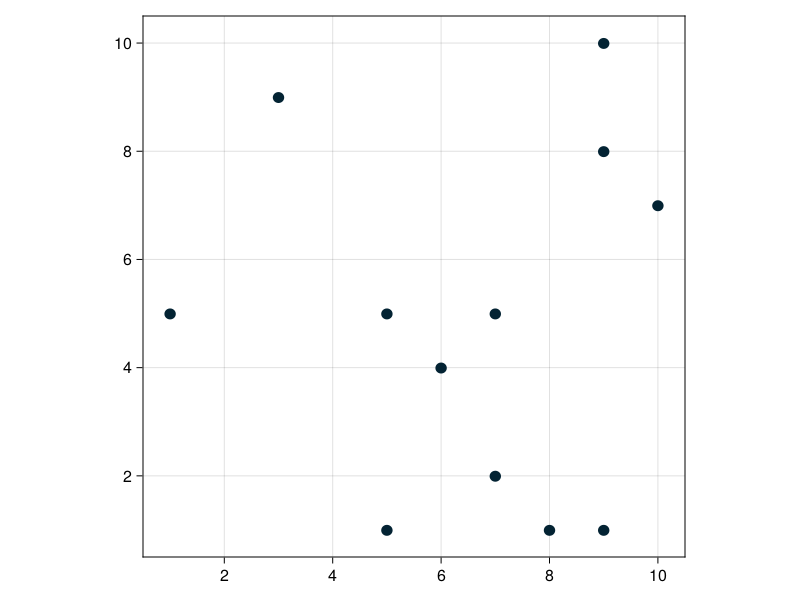

In [10]:
using ColorSchemes
colors=Dict(0=>:black,1=>:red,2=>:blue,3=>:green,4=>:yellow,5=>:orange,6=>:purple,7=>:pink,8=>:brown,9=>:cyan,10=>:gray)
densitycolor(a) = get(colorschemes[:thermal], a.near_cells, (1,10))

figure, _ = abmplot(model;ac = densitycolor)
figure # returning the figure displays it

In [91]:
model = model_init()
abmvideo(
    "schelling.mp4", model, agent_step!;
    framerate = 50, frames = 1000,ac = densitycolor,
    title = "Tumor growth"
)

In [51]:
genotype = BitArray([false for x in 1:10])
genes=findall(genotype .!=1)

if genes==[]
    print("a")
end
r=sample()
print(r)
if r!=Array()
    genotype[r]=1
end
genotype

MethodError: MethodError: no method matching sample()
Closest candidates are:
  sample(!Matched::AbstractWeights) at C:\Users\yomis\.julia\packages\StatsBase\XgjIN\src\sampling.jl:563
  sample(!Matched::AbstractArray) at C:\Users\yomis\.julia\packages\StatsBase\XgjIN\src\sampling.jl:432
  sample(!Matched::AbstractArray, !Matched::Integer; replace, ordered) at C:\Users\yomis\.julia\packages\StatsBase\XgjIN\src\sampling.jl:513
  ...